In [1]:
pip install gdown

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import gdown
import tarfile
import os

# URL of the dataset on Google Drive
url = 'https://drive.usercontent.google.com/download?id=107FTosYIeBn5QbynR46YG91nHcJ70whs&export=download&confirm=t&uuid=ac5bdb7e-1579-427d-92e4-c3cc1e39ede1'
# Output file name for downloaded dataset
output = 'train.tar'
# Check if the dataset file already exists
if not os.path.exists(output):
  print('Downloading dataset')
  gdown.download(url, output, quiet=False)
# Path to extract the dataset
extraction_path='./data/miniImageNet'
# Check if the extraction path already exists
if not os.path.exists(extraction_path):
# Open the tar file and extract its contents to the specified path
  with tarfile.open(output) as tar:
      tar.extractall(path=extraction_path)

In [3]:
# Importing necessary dependencies
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import os
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision
import time
from tempfile import TemporaryDirectory
import random
import numpy as np
from torchvision.io import read_image
import torchvision.transforms.functional as F
import time
torch.backends.cudnn.benchmark = True
plt.ion()

In [4]:
from timm import create_model
# Custom Vision Transformer (ViT) model class
class VIT_Model(nn.Module):
    def __init__(self, num_classes):
        super(VIT_Model, self).__init__()
        # Create Vision Transformer model with pre-trained weights
        self.model = create_model('vit_base_patch32_224', pretrained=True)
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)

    def forward(self, x):
        return self.model(x)


Reference : https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [5]:
# Function to display images
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Function to evaluate the model
def eval_func(net, data_loader):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        outs = net(images)
        preds = outs.argmax(dim=1)
        correct += preds.eq(labels).sum()
        num_images += len(labels)
    acc = correct / num_images
    return acc

# Function to train the model
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, set_lengths):
    since = time.time()
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()
    
    best_acc = 0.0
    train_losses = []
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)

        val_losses = []
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                correct = 0.0
                num_images = 0.0
                epoch_loss = 0.0

                for i_batch, (images, labels) in enumerate(dataloaders[phase]):
                    if use_cuda:
                        images = images.cuda()
                        labels = labels.cuda()

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(images)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            epoch_loss += loss.item()
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels)
                if phase == 'train':
                    train_losses.append(loss.item())
                else:
                    val_losses.append(loss.item())

                epoch_loss = running_loss / set_lengths[phase]
                epoch_acc = running_corrects.double() / set_lengths[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        
        model.load_state_dict(torch.load(best_model_params_path))
    return model, train_losses, val_losses

Hyperparameters


In [6]:
# Hyperparameters for training
batchsize = 256
learn_rate=0.0001
weight_decay=0.0001
epochs=10
momentum=0.09
step_size=2
gamma=0.01

In [7]:
data_folder='.\\data\\miniImageNet\\train'
dataset = datasets.ImageFolder(data_folder, transforms.Compose([
        transforms.Resize(224),
        
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        transforms.RandomCrop(224, padding=8),
        transforms.ToTensor(),
        
        transforms.Normalize((0.485, 0.456, 0.406), (0.4, 0.4, 0.4)),
    ]))
# Splitting the dataset into train, validation, and test sets
num_samples = len(dataset)
num_val = int(0.3 * num_samples)
num_test = int(0.2 * num_samples)
num_train = num_samples - num_val - num_test
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [num_train, num_val, num_test])

# Create DataLoaders for train, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batchsize, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize, shuffle=True, num_workers=2)

# Organize DataLoaders in a dictionary
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

# Store dataset sizes in a dictionary
dataset_sizes = {'train': num_train, 'val': num_val, 'test': num_test}

In [8]:
# Function to visualize model predictions on validation data
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                imshow(inputs.cpu().data[j])
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
# Setting the device based on GPU availability
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda:0


In [10]:
net = VIT_Model(64).to(device)
# Setting requires_grad to True for all parameters in the model
for p in net.parameters():
    p.requires_grad = True

In [11]:
optimizer = torch.optim.Adam(net.parameters(), lr=learn_rate, weight_decay=weight_decay, betas=(0.5, 0.999))
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
criterion = torch.nn.CrossEntropyLoss()

In [12]:
pretrained_model, train_losses, val_losses = train_model(net, dataloaders, criterion, optimizer, scheduler, epochs, dataset_sizes)

Epoch 0/9
----------
train Loss: 0.0035 Acc: 0.8022
val Loss: 0.0013 Acc: 0.9102

Epoch 1/9
----------
train Loss: 0.0009 Acc: 0.9390
val Loss: 0.0013 Acc: 0.9101

Epoch 2/9
----------
train Loss: 0.0004 Acc: 0.9699
val Loss: 0.0012 Acc: 0.9174

Epoch 3/9
----------
train Loss: 0.0002 Acc: 0.9856
val Loss: 0.0012 Acc: 0.9194

Epoch 4/9
----------
train Loss: 0.0002 Acc: 0.9876
val Loss: 0.0013 Acc: 0.9158

Epoch 5/9
----------
train Loss: 0.0001 Acc: 0.9894
val Loss: 0.0013 Acc: 0.9149

Epoch 6/9
----------
train Loss: 0.0001 Acc: 0.9922
val Loss: 0.0013 Acc: 0.9156

Epoch 7/9
----------
train Loss: 0.0001 Acc: 0.9933
val Loss: 0.0016 Acc: 0.9030

Epoch 8/9
----------
train Loss: 0.0001 Acc: 0.9896
val Loss: 0.0015 Acc: 0.9074

Epoch 9/9
----------
train Loss: 0.0001 Acc: 0.9912
val Loss: 0.0015 Acc: 0.9081

Training complete in 17m 14s
Best val Acc: 0.919358


In [13]:
# Evaluating the model on the test data
eval_acc = eval_func(pretrained_model, dataloaders['test'])
# Printing the accuracy on testing data
print('')
print('Accuracy on testing data: %f' % eval_acc)


Accuracy on testing data: 0.916146


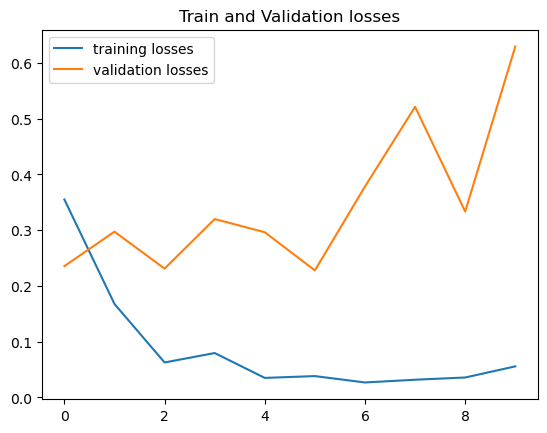

In [14]:
# Plotting training and validation losses
plt.title('Train and Validation losses')
plt.plot(train_losses, label='training losses')
plt.plot(val_losses, label='validation losses')
plt.legend()
plt.show()

In [15]:
# Saving the state dictionary of the pretrained model
torch.save(pretrained_model.state_dict(), 'ViT_Model_Save.pth')

In [16]:
# Setting up data transformations and creating DataLoader for training data
data_dir = '.\\data\\miniImageNet'

transform = transforms.Compose([
        transforms.Resize(224),
        
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        transforms.RandomCrop(224, padding=8),
        transforms.ToTensor(),
        
        transforms.Normalize((0.485, 0.456, 0.406), (0.4, 0.4, 0.4)),
    ])

# Creating ImageFolder dataset and DataLoader for training data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          transform)
                  for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train']}
class_names = image_datasets['train'].classes

In [17]:
# Function to visualize model predictions on training data
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            print(labels)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]} real : {class_names[j]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

tensor([17, 12, 42, 39], device='cuda:0')


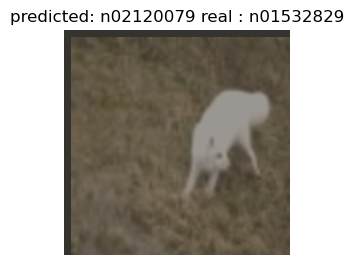

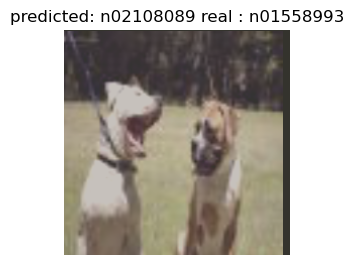

In [18]:
visualize_model(pretrained_model, num_images=2)